In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from bayes3d._mkl.table_scene_model import *
from bayes3d._mkl.utils import *
import matplotlib.pyplot as plt

In [3]:
import jax
from jax import jit, vmap
import jax.numpy as jnp
import os
import bayes3d as b3d
import trimesh

key = jax.random.PRNGKey(0)

In [4]:
import genjax
from genjax import gen

## Renderer and meshes

In [5]:
_scaling  = 1e-3
model_dir = os.path.join(b3d.utils.get_assets_dir(),"bop/ycbv/models")

meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    mesh = trimesh.load(mesh_path)
    mesh.vertices *= _scaling 
    meshes.append(mesh)


# Add invisible atomic table
mesh_path = os.path.join(b3d.utils.get_assets_dir(), "sample_objs/cube.obj")
mesh = trimesh.load(mesh_path)
mesh.vertices *= 1e-9
meshes.append(mesh)


In [6]:
w = 200
h = 200
f = 300
intr = b3d.Intrinsics(
    width = w, height = h,
    fx = f, fy = f,
    cx = w/2 - 0.5, cy = h/2 - 0.5,
    near = 1e-4, far = 5.0
)
b3d.setup_renderer(intr)
for mesh in meshes: b3d.RENDERER.add_mesh(mesh, center_mesh=True)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (224, 224, 1024)


In [7]:
def prep_im(Y, far=5.0, eps=1e-6):
    im = jnp.where(Y[:,:,2]>= far - eps, jnp.inf, Y[:,:,2])
    return im

## Table Scene

In [8]:
fname = f"table_scene_2"

data = jnp.load(f"data/likelihood_test/{fname}.npy", allow_pickle=True)
data = data.item()

scene_ch = data["choices"]
cam      = data["choices"]["camera_pose"]
table    = data["choices"]["root_pose_0"]
scene_model_args = data["args"]

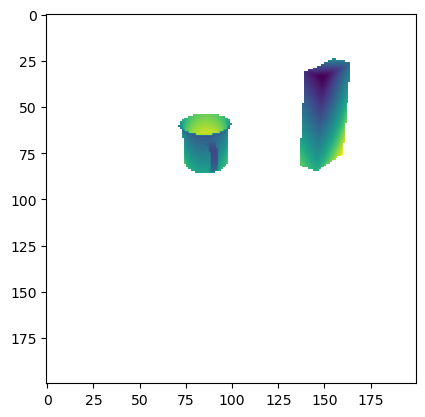

In [9]:
key = keysplit(key)

scene_model = make_table_scene_model()
w, tr = scene_model.importance(key, scene_ch, scene_model_args)
cam, ps, inds = tr.retval

X = b3d.RENDERER.render(inv(cam) @ ps , inds)

# =====================
plt.imshow(prep_im(X))

In [12]:
w_orig = h_orig = 200
w_att  = h_att  = 50
fx     = fy     = 300
center = jnp.array([90., 70.])

intr = b3d.Intrinsics(
    width = 2*w_att+1, height = 2*h_att+1,
    fx    = fx,    fy     = fy,
    cx    = w_orig/2 - 0.5 + w_att - center[0],  cy = h_orig/2 - 0.5  + h_att - center[1],
    near = 1e-4, 
    far  = 5.0
)
b3d.setup_renderer(intr)
for mesh in meshes: b3d.RENDERER.add_mesh(mesh, center_mesh=True)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


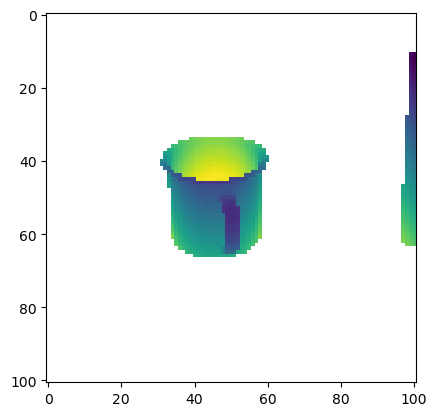

In [13]:
X = b3d.RENDERER.render(inv(cam) @ ps , inds)

# =====================
plt.imshow(prep_im(X))

## Scene model

In [14]:
scene_model_args = (
    jnp.arange(2),
    jnp.arange(22),
    jnp.array([-jnp.ones(3)*100.0, jnp.ones(3)*100.0]),
    jnp.array([jnp.array([-0.2, -0.2, -2*jnp.pi]), jnp.array([0.2, 0.2, 2*jnp.pi])]),
    b3d.RENDERER.model_box_dims
)
scene_model  = make_table_scene_model()

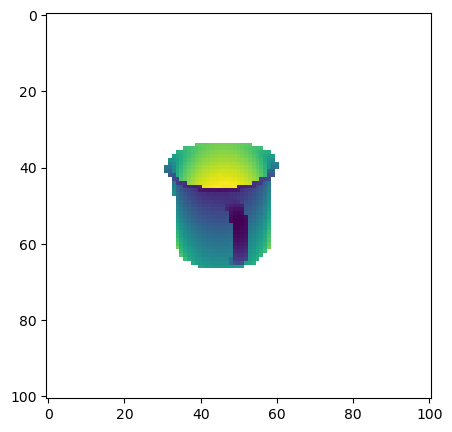

In [15]:
key = keysplit(key)
_, tr0 = scene_model.importance(key, scene_ch, scene_model_args)

cam, ps, inds = tr0.retval
Y = b3d.RENDERER.render(inv(cam) @ ps , inds)

# ========================
plt.figure(figsize=(5,5))
plt.imshow(prep_im(Y, far=4.5))

In [16]:
from bayes3d._mkl.plotting import *


def get_linear_grid(shape, bounds, flat=False):
    """Create a (linear) grid of a given shape and bounds."""
    
    linspaces = [jnp.linspace(*b, d) for b,d in zip(bounds, shape)]
    vs = jnp.stack(jnp.meshgrid(*linspaces, indexing='ij'), axis=-1)
    if flat: vs = vs.reshape(-1,len(shape))
    
    return vs

In [17]:
def render_contact(key, tr0, v):
    ch = genjax.choice_map({"contact_params_1": v})
    diffs = argdiffs(tr0.args)
    (_, w, tr1, _) = tr0.update(key, ch, diffs)
    cam, ps, inds = tr1.retval
    Y = b3d.RENDERER.render(inv(cam) @ ps , inds)
    return Y

In [18]:

def make_eval_contact(score_func):

    def _eval_contact(key, tr0, v, X):
        ch = genjax.choice_map({"contact_params_1": v})
        diffs = argdiffs(tr0.args)
        (_, w, tr1, _) = tr0.update(key, ch, diffs)
        cam, ps, inds = tr1.retval
        Y = b3d.RENDERER.render(inv(cam) @ ps , inds)
        return score_func(Y,X)


    eval_contact = jit(vmap(_eval_contact, (None,None,0, None)))
    
    return eval_contact


In [103]:
# def score_against_latent(Y):
    # D = X[...,2] - Y[...,2]

    
def score_images(rendered, observed):
    distances = jnp.linalg.norm(observed - rendered, axis=-1)
    logps = jax.scipy.stats.norm.pdf(
        distances,
        loc   = 0.0, 
        scale = 0.1
    )
    logps = jnp.where(distances < 0.01, 0.1 + logps, 0.1)
    image_probability = logps.mean()
    return image_probability


# def score_images(rendered, observed):
#     distances = jnp.linalg.norm(observed - rendered, axis=-1)
#     width = 0.02
#     # probabilities_per_pixel = (distances < width/2) / width
#     return (distances < width/2).sum()


score_func = score_images
eval_contact = make_eval_contact(score_func)

(42875, 3)
(101, 101)


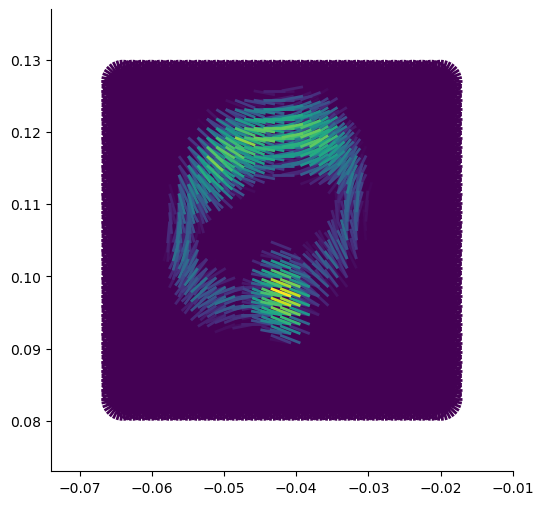

In [104]:
dx  = 0.022
dhd = jnp.pi
v0 = scene_ch["contact_params_1"]
vs = get_linear_grid((35, 35, 35), ((-dx,dx), (-dx,dx), (-dhd,dhd)), flat=True)
vs += jnp.array([-0.042,0.105, 0.0])

print(vs.shape)
print((b3d.RENDERER.intrinsics.height, b3d.RENDERER.intrinsics.width))

sc = eval_contact(key, tr0, vs, X)

r = 0.003
# =======================================
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
zoom_in(vs[:,:2], 0.01, ax=ax)
plot_poses(vs, sc, r=r, linewidth=2, ax=ax, q=0.98)
# plot_pose(scene_ch["contact_params_1"], r=r/2, c="red")
# plt.scatter(*v0[:2], c="r", s=10)

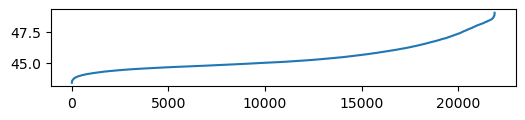

In [42]:
order = jnp.argsort(sc)
# =================
plt.figure(figsize=(6,1))
plt.plot(sc[order])

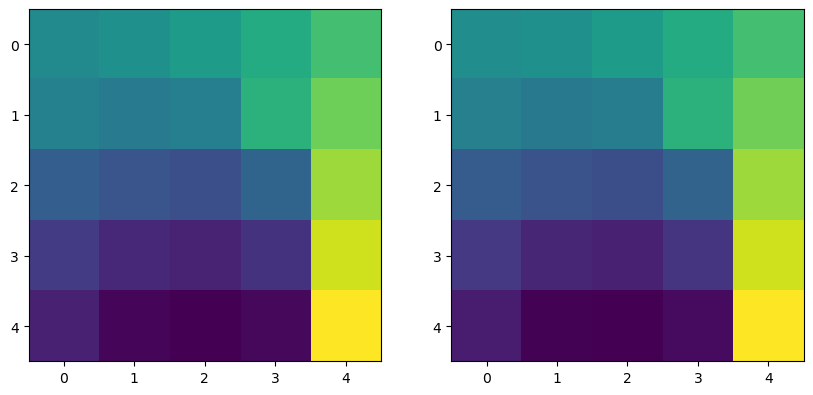

In [54]:
order = jnp.argsort(sc)

tr1 = update(key, tr0, vs[order[-1]])

X, Y = tr1.retval

fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(prep_im(X, far=4.5))
axs[1].imshow(prep_im(Y, far=4.5))

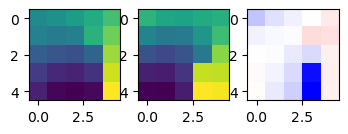

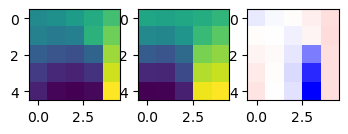

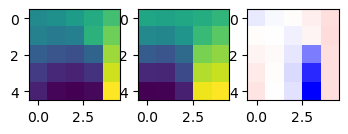

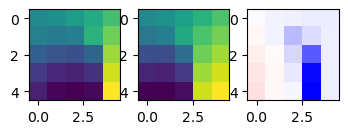

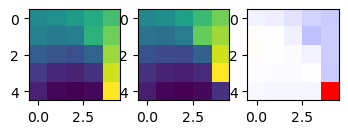

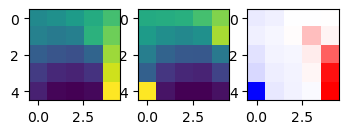

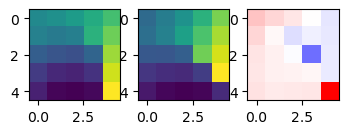

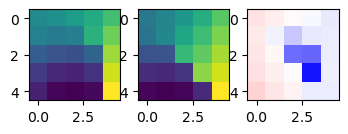

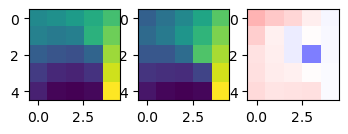

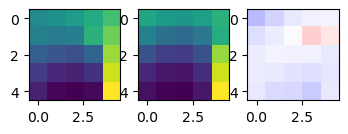

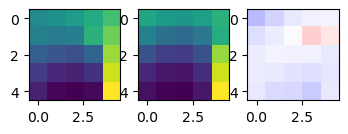

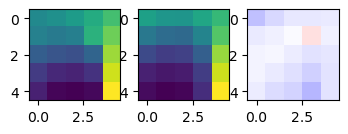

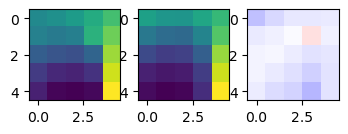

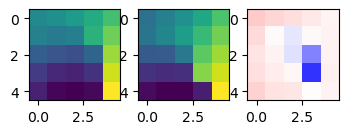

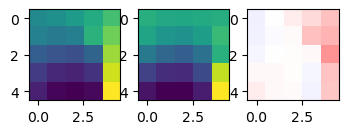

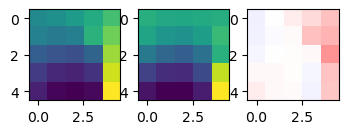

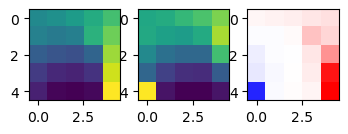

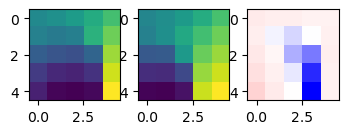

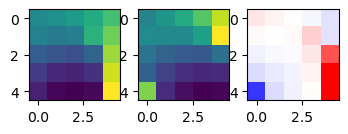

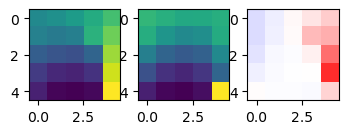

In [59]:
order = jnp.argsort(sc)[::-1]

for i in range(20):
    tr1 = update(key, tr0, vs[order[i]])

    X, Y = tr1.retval
    fig, axs = plt.subplots(1,3, figsize=(4,2))
    axs[0].imshow(prep_im(X, far=4.5))
    axs[1].imshow(prep_im(Y, far=4.5))
    axs[2].imshow(X[...,2] - Y[...,2], cmap="bwr", vmin=-0.02, vmax=0.02)

## Down sampling

In [66]:
from jax._src.image import scale

scale.resize?

Signature:
scale.resize(
    image,
    shape: collections.abc.Sequence[typing.Union[int, typing.Any]],
    method: Union[str, jax._src.image.scale.ResizeMethod],
    antialias: bool = True,
    precision=<Precision.HIGHEST: 2>,
)
Docstring:
Image resize.

The ``method`` argument expects one of the following resize methods:

``ResizeMethod.NEAREST``, ``"nearest"``
  `Nearest neighbor interpolation`_. The values of ``antialias`` and
  ``precision`` are ignored.

``ResizeMethod.LINEAR``, ``"linear"``, ``"bilinear"``, ``"trilinear"``, ``"triangle"``
  `Linear interpolation`_. If ``antialias`` is ``True``, uses a triangular
  filter when downsampling.

``ResizeMethod.CUBIC``, ``"cubic"``, ``"bicubic"``, ``"tricubic"``
  `Cubic interpolation`_, using the Keys cubic kernel.

``ResizeMethod.LANCZOS3``, ``"lanczos3"``
  `Lanczos resampling`_, using a kernel of radius 3.

``ResizeMethod.LANCZOS5``, ``"lanczos5"``
  `Lanczos resampling`_, using a kernel of radius 5.

.. _Nearest neighbor interpo

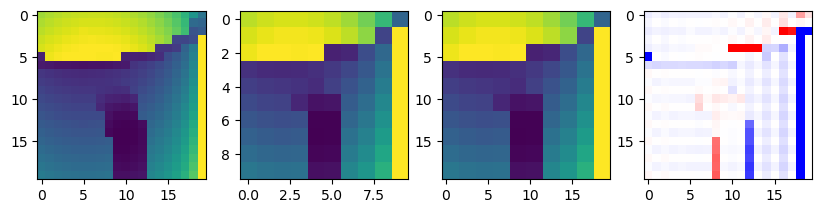

In [64]:
method = ["nearest", "bilinear","trilinear", "triangle", "cubic"][0]

Y_down = scale.resize(Y[...,2], (10,10), method)
Y_up   = scale.resize(Y_down, (20,20), method)


# =================================
fig, axs = plt.subplots(1,4,figsize=(10,3))
axs[0].imshow(Y[...,2], vmax=1.)
axs[1].imshow(Y_down, vmax=1.)
axs[2].imshow(Y_up, vmax=1.)
axs[3].imshow(Y[...,2] - Y_up, cmap="bwr", vmin=-0.05,vmax=0.05)